In [532]:
import sympy as sp
import graphviz
from IPython.display import Markdown, Latex, display
from sympy.abc import x,y,z,a,b,c,d,A,B,C, D,S
import pygraphviz
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
from sympy import Add, Mul, Integer, Symbol

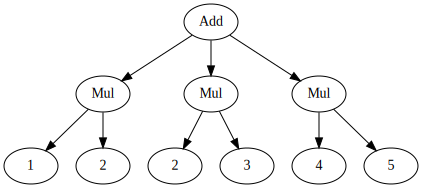

In [193]:
dotFormat = sp.dotprint(e)
graphviz.Source(dotFormat)

() {'color': 'black', 'label': (x**2)**3 + 1, 'shape': 'ellipse', 'kind': 'Add'}
(0,) {'color': 'black', 'label': (x**2)**3, 'shape': 'ellipse', 'kind': 'Pow'}
(0, 0) {'color': 'black', 'label': x**2, 'shape': 'ellipse', 'kind': 'Pow'}
(0, 0, 0) {'color': 'black', 'label': x, 'shape': 'ellipse', 'kind': 'Symbol'}
(0, 0, 1) {'color': 'black', 'label': 2, 'shape': 'ellipse', 'kind': 'Integer'}
(0, 1) {'color': 'black', 'label': 3, 'shape': 'ellipse', 'kind': 'Integer'}
(1,) {'color': 'black', 'label': 1, 'shape': 'ellipse', 'kind': 'One'}


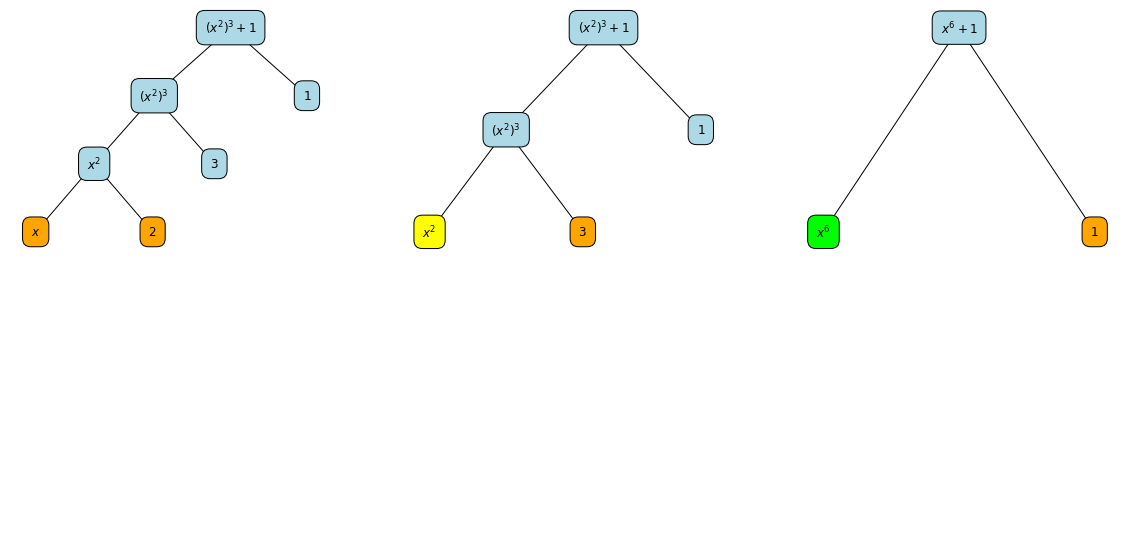

INPUT: (x**2)**3 + 1
OUTPUT: x**6 + 1
SOLUTION 1: (x**2)**3 + 1 = (x**2)**3 + 1 = (x**2)**3 + 1 = x**6 + 1 = x**6 + 1
SOLUTION 2: (x**2)**3 + 1 = (x**2)**3 + 1 = (x**2)**3 + 1 = x**6 + 1 = 1 + x**6


In [560]:
class TraverseSolver:
    def __init__(self, expr):
        self.expr = expr
        self.trash = {}
        
    def set_tree(self):
        # sp.preorder_traversal(self.expr) is the only way to get func and args
        self.Tree = nx.nx_agraph.from_agraph(pygraphviz.AGraph(sp.dotprint(self.expr)))
        self.Tree = nx.relabel_nodes(self.Tree, dict(zip(self.Tree.nodes, 
                                             map(lambda x: eval(x[x.rfind('_')+1:]), self.Tree.nodes))))
        nx.set_node_attributes(self.Tree, name='label', 
                               values=dict(zip(self.Tree.nodes(), sp.preorder_traversal(self.expr))))
        nx.set_node_attributes(self.Tree, name='kind', 
                               values=dict(zip(self.Tree.nodes(), 
                                               map(lambda x: x.func.__name__, 
                                                   nx.get_node_attributes(self.Tree, 'label').values()))))
        for x, y in self.Tree.nodes(data=True):
            print(x, y)
        
    def get_baseNode(self):
        return next(iter(self.Tree.nodes))
        
    def set_levels(self):
        d = nx.single_source_shortest_path_length(self.Tree, 
                                                  self.get_baseNode()) #assume levels are ascending; temporary fix
        self.levels = dict((k, list(g)) for k, g in groupby(d, key = lambda x: d[x])) #level -> node
        
    def get_levels(self):
        return self.levels
    
    def set_color(self, node, color, certainly=True):
        if certainly:
            self.Tree.nodes[node]['color'] = color
            
    def set_label(self, node, label):
        self.Tree.nodes[node]['label'] = label
        
    def get_label(self, node):
        return self.Tree.nodes[node]['label']

    def display_graph(self, fig, n, nshape=(2, 3)):      
        ax = fig.add_subplot(*nshape, n)
        pos = graphviz_layout(self.Tree, prog='dot')
        colors = nx.get_node_attributes(self.Tree, 'color')    
        nx.draw(self.Tree, pos = pos, nodelist=[])
        # draw self.Tree bbox by bbox:
        for n in self.Tree.nodes():
            nx.draw(nx.subgraph(self.Tree, [n]), pos={n:pos[n]}, 
                    labels = {n:'$'+sp.latex(self.get_label(n))+'$'}, nodelist=[],
                    bbox=dict(facecolor=colors[n], edgecolor='black', boxstyle='round,pad=0.7'))
    
            
    def resolve(self):
        levels = self.get_levels()
        for editLevel in reversed(levels):
            for editNode in levels[editLevel]:
                args = [self.get_label(node) for node in self.Tree[editNode]] #each ancestor (make sure there are ones)
                if not self.get_label(editNode).is_Atom:
                    if args:
                        self.set_label(editNode, self.get_label(editNode).func(*args, evaluate=False))
                    
    def add_trash(self, level, node):
        if level in self.trash:
            self.trash[level].append(node)
        else:
            self.trash[level] = [node]
        
    def remove_trash(self):
        for level in self.trash:
            for node in self.trash[level]:
                self.levels[level].remove(node)
                self.Tree.remove_node(node)
        self.trash = {}
            
    def evaluate(self, level, display_graph=True):
        for node in self.get_levels()[level]:
            beforeEval = self.get_label(node)
            if not beforeEval.is_Atom:
                afterEval = beforeEval.func(*beforeEval.args, evaluate=True) #is beforeEval different with afterEval
                if beforeEval != afterEval:
                    self.set_label(node, afterEval)
                    self.set_color(node, 'lime', certainly=display_graph)                        
                    self.add_trash(level, node)
                else:
                    self.set_color(node, 'yellow', certainly=display_graph)
                    self.add_trash(level, node)
            else:
                self.set_color(node, 'orange', certainly=display_graph)
                self.add_trash(level, node)
        
    def solve(self, display_graph=True, nshape=(2, 3)):
        self.set_tree()
        self.set_levels()
        solutionSteps = [self.expr] #first step contains initial expression
        
        # set figure and node colors
        if display_graph:
            fig = plt.figure(figsize=(20,10))
        for node in self.Tree.nodes(): 
            self.set_color(node, 'lightblue', certainly=display_graph)
            
        # remove old layer, evaluate next layer and resolve with no evaluation
        for activeLevel in reversed(self.get_levels()):
            self.remove_trash()                   
            self.evaluate(activeLevel, display_graph=display_graph)
            self.resolve()    
            solutionSteps.append(self.get_label(self.get_baseNode()))  
            if display_graph:
                self.display_graph(fig, n=len(solutionSteps)-1, nshape=nshape)
        if display_graph:
            plt.show()
        return solutionSteps

e = '-1*(2*3-5*7)+5*4'
e = '(x+1)*(x+2)'
e = '(x**2)**3+1'
#e = 'sin(x)**2 + cos(x)**2'
expr1 = sp.sympify(e, evaluate=False)
expr2 = sp.sympify(e, evaluate=True)
steps = TraverseSolver(expr1).solve(display_graph=True, nshape=(2, 3))

print('INPUT:', expr1)
print('OUTPUT:', expr2)
print('SOLUTION 1:', ' = '. join([str(step) for step in steps]))
print('SOLUTION 2:', ' = '. join([sp.StrPrinter(dict(order='none'))._print(step) for step in steps]))

In [88]:
def LatexEnv(name, core, c=None):
    if c==None: c=''
    else: c=f'{{{c}}}'
    return f'\\begin{{{name}}}{c} {core} \\end{{{name}}}'
LatexEnv('cases', 'abc')

'\\begin{cases} abc \\end{cases}'

In [3]:
def LatexArgs(name, *args):
    return f'\\{name}'+''.join(f'{{{arg}}}' for arg in args)
LatexArgs('frac','-b+\sq','n')

'\\frac{-b+\\sq}{n}'

In [12]:
def LatexEq(steps):
    def _tex(n):
        if type(n) is str: return n
        else: return sp.latex(n)
        
    return ' = '.join([_tex(s) for s in steps])

LatexEq([(-b+sp.sqrt(b**2-4*a*c))/(2*a), 'b', 'c'])

'\\frac{- b + \\sqrt{- 4 a c + b^{2}}}{2 a} = b = c'

In [11]:
def latexy(f):
    return f'${f}$'

In [130]:
from sympy.printing.latex import LatexPrinter

In [141]:
x,y = sp.symbols('x y')
u = sp.Function('u')(x,y)
ux,uy,uxx,uxy,uyy = sp.symbols("u_x u_y u_xx u_xy u_yy")
args = uxx , -2*sp.sin(x)*uxy, -sp.cos(x)**2*uyy, -2*ux, +(2-sp.cos(x)+2*sp.sin(x))*uy

expr = sp.Add(*args, evaluate=False)
from sympy.printing.str import StrPrinter # or LatexPrinter from .latex)
StrPrinter(dict(order='none'))._print(expr)

'u_xx - 2*u_xy*sin(x) - u_yy*cos(x)**2 - 2*u_x + u_y*(2 - cos(x) + 2*sin(x))'

In [81]:
S.One

1

In [80]:
from sympy import S

In [22]:
eq = sp.Add(x, y, z, evaluate=False)
eq

-4*a*c + b**2 - 2

In [24]:
eq.as_ordered_terms('rev-lex'), eq.as_ordered_terms()

([-2, b**2, -4*a*c], [-4*a*c, b**2, -2])

In [19]:
sp.Add(*eq.as_ordered_terms('rev-lex'), evaluate=False)

-4*a*c + b**2 - 2

In [6]:
from pytexit import py2tex
py2tex('(-b+sqrt(b**2-4*a*c))/(2*a)')

<IPython.core.display.Latex object>

$$\frac{-b+\sqrt{b^2-4a c}}{2a}$$


'$$\\frac{-b+\\sqrt{b^2-4a c}}{2a}$$'

In [11]:
from sympy.abc import sigma, epsilon, T, t
L = sp.latex(epsilon*sigma*t**4, symbol_names={t:"T"})
L

'T^{4} \\epsilon \\sigma'

### Bugs
Can't set order of summands while counting determinant of 3*3 matrix

In [4]:
import numpy as np
A = np.array([[5, 4, 3], [2, 3, 0], [0, 3, 4]], dtype=int)
B = np.array([[5, 4], [2, 3], [0, 3]], dtype=int)
print(A)
print(B)

[[5 4 3]
 [2 3 0]
 [0 3 4]]
[[5 4]
 [2 3]
 [0 3]]
